### Kaggle's Titanic competition  - by tawonque

In [1]:
### Modules ###

import os
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import neighbors as grid_search

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
os.getcwd()

'/Users/Tavo'

### Import data

In [3]:
titanic = pd.read_csv('./Data_science/Titanic/train.csv')
test = pd.read_csv('./Data_science/Titanic/test.csv')

### Explore and edit input files ###
titanic.head()
titanic.dtypes

test.head()
test.dtypes

titanic.info()
print('o+o+o+o+o+o+o+o')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
o+o+o+o+o+o+o+o
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           41

### Embarking port

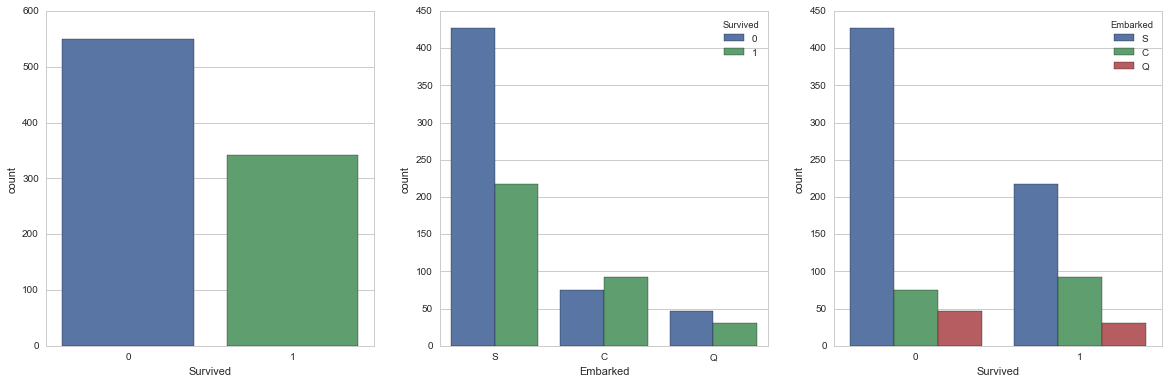

In [4]:
fig = plt.figure(figsize=(20,6))
#
plt.subplot2grid((1,3), (0,0))
sns.countplot(x='Survived', data=titanic)
plt.subplot2grid((1,3), (0,1))
sns.countplot(x='Embarked', hue='Survived', data=titanic)
plt.subplot2grid((1,3), (0,2))
sns.countplot(x='Survived', hue='Embarked', data=titanic)

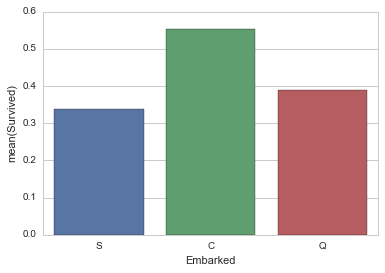

In [5]:
#For some reason there is a higher survival rate for the passengers embarked in C. Perhpas is an artefact 
#related either to the number of passengers embarked (less representative sample) or the fares paid (more rich passengers 
#embarking here or there. See Pclass analysis below)

embark_percent_titanic = titanic[['Embarked', 'Survived']].groupby(['Embarked'],\
as_index=False).mean()
#
sns.barplot(x='Embarked', y='Survived', data=embark_percent_titanic,order=['S','C','Q'])

In [6]:
#Embarking port should not have any prediction power per se, but let's leave it just
#in case and create some dummy variables
embark_dummies_titanic  = pd.get_dummies(titanic['Embarked'])
titanic = titanic.join(embark_dummies_titanic)
#titanic = titanic.drop(['Embarked'], axis=1, inplace=True)
embark_dummies_test  = pd.get_dummies(test['Embarked'])
test = test.join(embark_dummies_test)

### Fare

(array([ 519.,  197.,   55.,   47.,   20.,   15.,    7.,    9.,    2.,
           0.,    5.,    4.,    8.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    3.]),
 array([   0.      ,   20.493168,   40.986336,   61.479504,   81.972672,
         102.46584 ,  122.959008,  143.452176,  163.945344,  184.438512,
         204.93168 ,  225.424848,  245.918016,  266.411184,  286.904352,
         307.39752 ,  327.890688,  348.383856,  368.877024,  389.370192,
         409.86336 ,  430.356528,  450.849696,  471.342864,  491.836032,
         512.3292  ]),
 <a list of 25 Patch objects>)

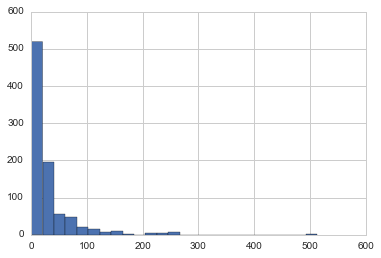

In [7]:
#Average fare for survivors and victims
mean_fare_survive = titanic[['Fare', 'Survived']].groupby(['Survived']).mean()#Histograms of fares
plt.hist(titanic['Fare'],bins=25)

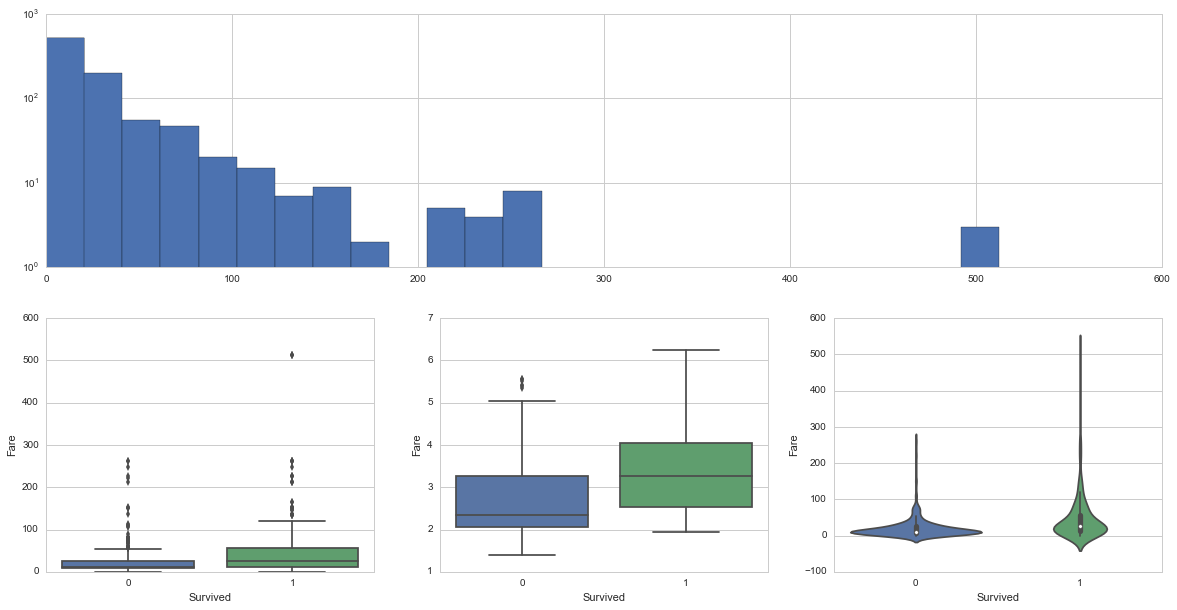

In [8]:
##Histograms of fares and other plots
fig = plt.figure(figsize=(20,10))
#
plt.subplot2grid((2,1), (0,0))
plt.hist(titanic['Fare'],bins=25, log=True) #Log turned on just to exagerate the less frequent values
plt.subplot2grid((2,3), (1,0))
sns.boxplot(x='Survived', y='Fare', data=titanic)
plt.subplot2grid((2,3), (1,1))
sns.boxplot(x='Survived', y=np.log(titanic.Fare), data=titanic) ##Log turned on just for exageration
plt.subplot2grid((2,3), (1,2))
sns.violinplot(x='Survived', y='Fare', data=titanic)

### Age

In [9]:
survived_age = titanic[titanic.Survived == 1].Age
dead_age = titanic[titanic.Survived == 0].Age

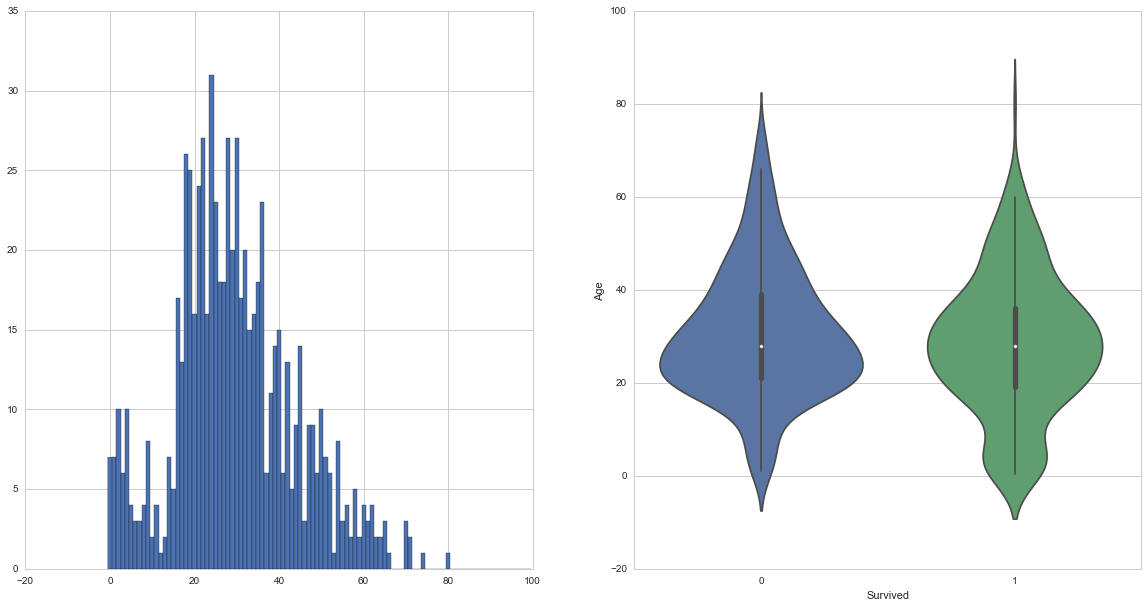

In [10]:
##Histograms and other plots
fig = plt.figure(figsize=(20,10))
#
plt.subplot2grid((1,2), (0,0))
#plt.hist([survived_age, dead_age], stacked=True, align='left', range=(0,100), color = ['b','r'], bins=100)
plt.hist(titanic['Age'], align='left', range=(0,100), bins=100)
plt.subplot2grid((1,2), (0,1))
sns.violinplot(x='Survived', y='Age', data=titanic, ylim=(0,100))

In [11]:
#Notice that the survival rate of children (<15 y) and old people (>60 y)
#We should perhaps separate these two groups and make an indicator variable for each. *See Sex category below

### Family variables: SibSp and Parch

/Users/Tavo/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


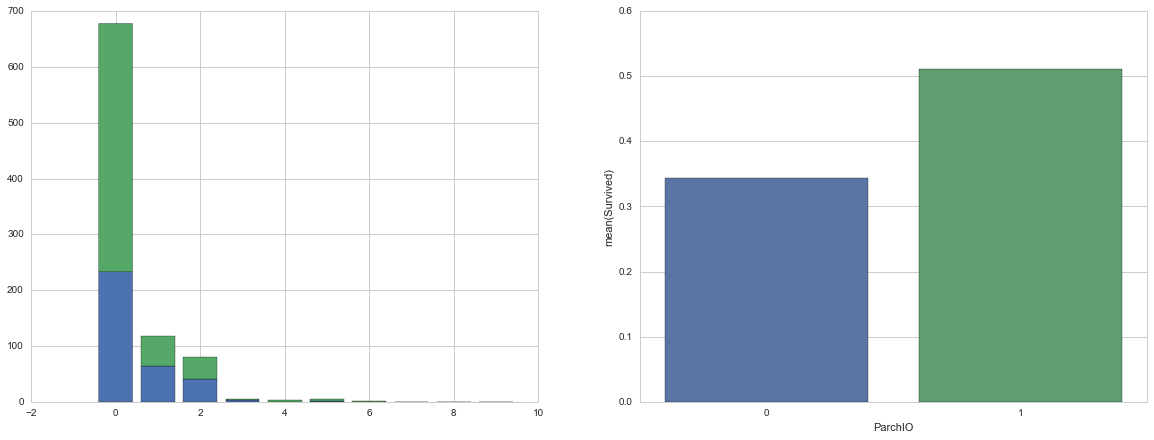

In [12]:
#Parents and children
survived_Parch = titanic[titanic.Survived == 1].Parch.dropna()
dead_Parch = titanic[titanic.Survived == 0].Parch.dropna()

titanic['ParchIO'] = titanic['Parch']
titanic['ParchIO'].loc[titanic['Parch'] > 0] = 1
titanic['ParchIO'].loc[titanic['Parch'] == 0] = 0
Parch_percent = titanic[['Survived', 'ParchIO']].groupby(['ParchIO'], as_index=False).mean()

test['ParchIO'] = test['Parch']
test['ParchIO'].loc[test['Parch'] > 0] = 1
test['ParchIO'].loc[test['Parch'] == 0] = 0

fig = plt.figure(figsize=(20,7))
#
plt.subplot2grid((1,2), (0,0))
plt.hist([survived_Parch, dead_Parch], stacked=True, align='left', range=(0,10), bins=10)
plt.subplot2grid((1,2), (0,1))
sns.barplot(x='ParchIO', y='Survived', data=Parch_percent)

/Users/Tavo/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


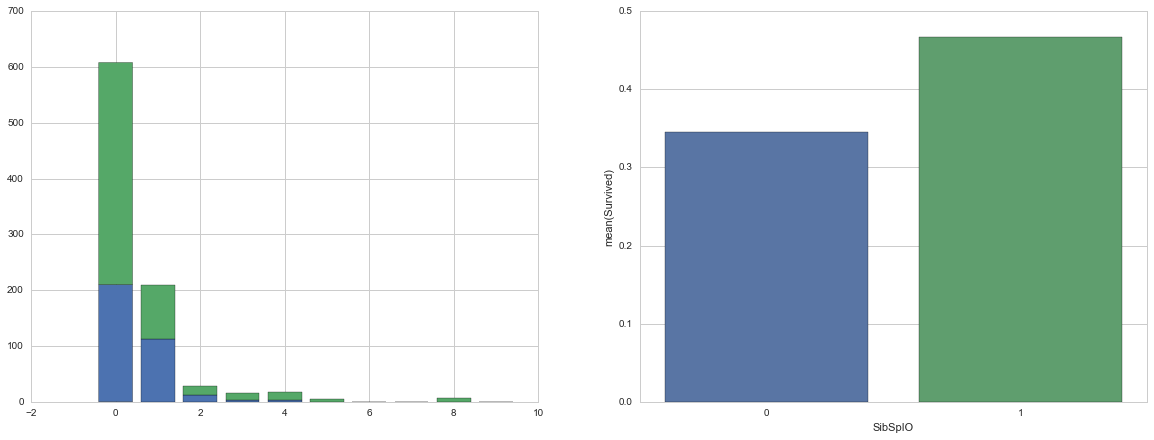

In [13]:
#Siblings and spouse
survived_SibSp = titanic[titanic.Survived == 1].SibSp.dropna()
dead_SibSp = titanic[titanic.Survived == 0].SibSp.dropna()

titanic['SibSpIO'] = titanic.SibSp
titanic['SibSpIO'].loc[titanic['SibSp'] > 0] = 1
titanic['SibSpIO'].loc[titanic['SibSp'] == 0] = 0
SibSp_percent = titanic[['Survived', 'SibSpIO']].groupby(['SibSpIO'], as_index=False).mean()

test['SibSpIO'] = test.SibSp
test['SibSpIO'].loc[test['SibSp'] > 0] = 1
test['SibSpIO'].loc[test['SibSp'] == 0] = 0

fig = plt.figure(figsize=(20,7))
#
plt.subplot2grid((1,2), (0,0))
plt.hist([survived_SibSp, dead_SibSp], stacked=True, align='left', range=(0,10), bins=10)
plt.subplot2grid((1,2), (0,1))
sns.barplot(x='SibSpIO', y='Survived', data=SibSp_percent)

/Users/Tavo/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


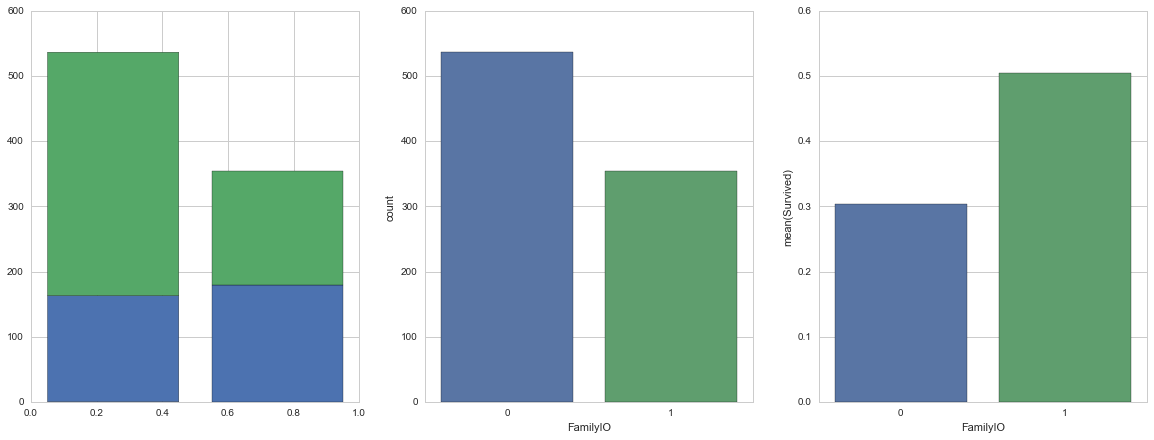

In [14]:
#Combining the two '''Let's start with a simple case and just use the column FamilyIO, ie. traveling alone or accompanied.'''
titanic['Family'] = titanic.Parch + titanic.SibSp
test['Family'] = test.Parch + test.SibSp

survived_Family = titanic[titanic.Survived == 1].Family.dropna()
dead_Family = titanic[titanic.Survived == 0].Family.dropna()

#Convert to binary variable
titanic['FamilyIO'] = titanic.Family
titanic['FamilyIO'].loc[titanic['FamilyIO'] > 0] = 1
titanic['FamilyIO'].loc[titanic['FamilyIO'] == 0] = 0

survived_FamilyIO = titanic[titanic.Survived == 1].FamilyIO.dropna()
dead_FamilyIO = titanic[titanic.Survived == 0].FamilyIO.dropna()

family_percent = titanic[['Survived', 'FamilyIO']].groupby(['FamilyIO'], as_index=False).mean()

test['FamilyIO'] = test.Family
test['FamilyIO'].loc[test['FamilyIO'] > 0] = 1
test['FamilyIO'].loc[test['FamilyIO'] == 0] = 0

fig = plt.figure(figsize=(20,7))
#
plt.subplot2grid((1,3), (0,0))
plt.hist([survived_FamilyIO, dead_FamilyIO], stacked=True, bins=2)
plt.subplot2grid((1,3), (0,1))
sns.countplot(x='FamilyIO', data=titanic)
plt.subplot2grid((1,3), (0,2))
sns.barplot(x='FamilyIO', y='Survived', data=family_percent)

### Sex

/Users/Tavo/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


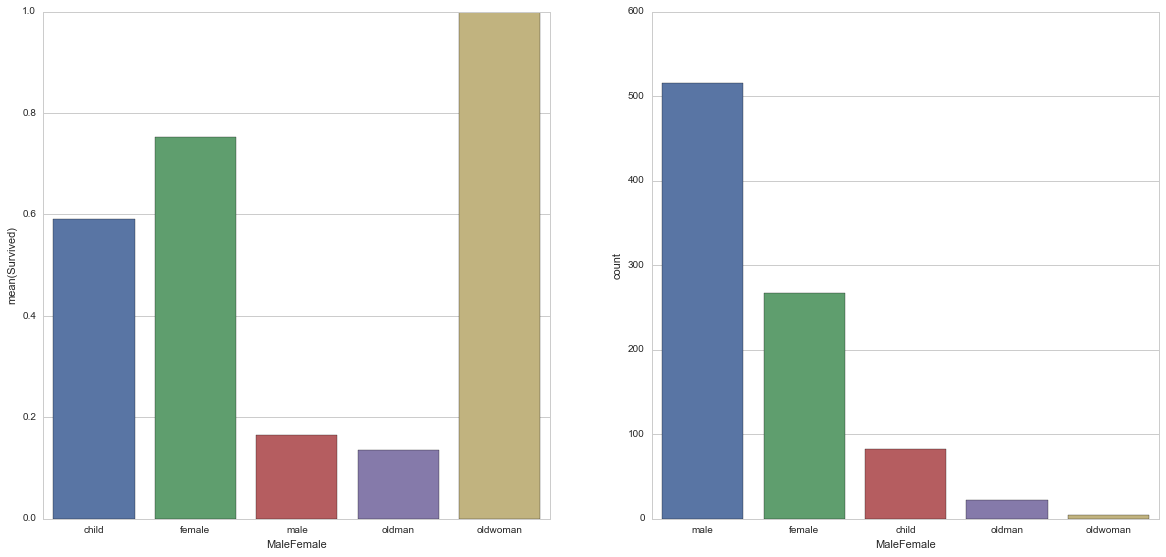

In [15]:
'''Shall we distinguish between males, females and children?
What is a children? Less than 12, 14, 16?
Let's start with the assumption that children means less than 12'''

titanic['MaleFemale'] = titanic.Sex
titanic['MaleFemale'].loc[titanic.Age <=15] = 'child'
titanic['MaleFemale'].loc[(titanic.Age >=60) & (titanic.Sex == 'male')] = 'oldman'
titanic['MaleFemale'].loc[(titanic.Age >=60) & (titanic.Sex == 'female')] = 'oldwoman'
Sex_percent = titanic[['Survived', 'MaleFemale']].groupby(['MaleFemale'], as_index=False).mean()

'''We should also try to understand if there is a correlation between sex and traveling alone
We could try that later on'''

fig = plt.figure(figsize=(20,20))
#
plt.subplot2grid((2,2), (1,0))
sns.barplot(x='MaleFemale', y='Survived', data=Sex_percent)
plt.subplot2grid((2,2), (1,1))
sns.countplot(x='MaleFemale', data=titanic)

In [16]:
#There are not too many samples for older men and women (>60 y), so I have doubts about increasing the complexity 
#of the model.
#Let's keep it simple for now...

titanic['MaleFemale'].loc[(titanic.MaleFemale == 'oldman')] = 'male'
titanic['MaleFemale'].loc[(titanic.MaleFemale == 'oldwoman')] = 'female'

#Add dummies variable
sex_dummies_titanic = pd.get_dummies(titanic.MaleFemale)
titanic = titanic.join(sex_dummies_titanic)

test['MaleFemale'] = test.Sex
test['MaleFemale'].loc[(test.Age <=15)] = 'child'
sex_dummies_test = pd.get_dummies(test.MaleFemale)
test = test.join(sex_dummies_test)

/Users/Tavo/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
print(sex_dummies_titanic.head())
titanic.head()

   child  female  male
0    0.0     0.0   1.0
1    0.0     1.0   0.0
2    0.0     1.0   0.0
3    0.0     1.0   0.0
4    0.0     0.0   1.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Q,S,ParchIO,SibSpIO,Family,FamilyIO,MaleFemale,child,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.0,1.0,0,1,1,1,male,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0.0,0.0,0,1,1,1,female,0.0,1.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,1.0,0,0,0,0,female,0.0,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0.0,1.0,0,1,1,1,female,0.0,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.0,1.0,0,0,0,0,male,0.0,0.0,1.0


### Pclass

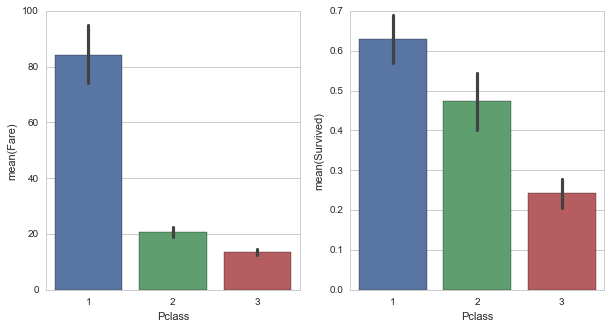

In [18]:
'''The class can be a proxy for the fare paid, which seems to have an effect. 
Let's investigate the class of travel and if it shows some similarities to the 
fares variables, we will discard the latter nd use Pclass in the initial prediction attempt'''

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x='Pclass', y='Fare', data=titanic, ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=titanic, ax=axis2)

Pclass_dummies_titanic = pd.get_dummies(titanic.Pclass, prefix='clas')
titanic = titanic.join(Pclass_dummies_titanic)

Pclass_dummies_test = pd.get_dummies(test.Pclass, prefix='clas')
test = test.join(Pclass_dummies_test)

### Conclusions from preliminary analysis
From the charts and the preliminary analysis, we could say a few things://
-o- Sex:
-o- Age:
-o- Family members:
-o- Cabin: large number of NaNs, so we will ignore for a while. However, there is
room for some information there. Cabin start with a letter, which could give information
on the location of the cabin? Or is the first number important? What deck were they?
However, Could the fare or the class be a proxy for cabin location? 
-o- Class:
-o- Fare:')

### Dataframe edition

Now let's see our dataframe and make it ready for analysis

In [19]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
C              891 non-null float64
Q              891 non-null float64
S              891 non-null float64
ParchIO        891 non-null int64
SibSpIO        891 non-null int64
Family         891 non-null int64
FamilyIO       891 non-null int64
MaleFemale     891 non-null object
child          891 non-null float64
female         891 non-null float64
male           891 non-null float64
clas_1         891 non-null float64
clas_2         891 non-null float64
clas_3         891 

In [20]:
titanic.Age.describe()

/Users/Tavo/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%             NaN
50%             NaN
75%             NaN
max       80.000000
Name: Age, dtype: float64

In [21]:
titanic.Age.head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [22]:
#titanic.csv: two missing values in 'embarked', a few more in 'age'
titanic['Embarked'] = titanic['Embarked'].fillna('S')
test.Embarked = test.Embarked.fillna('S')
#Let's fill the missing ages with samples from a ditribution based on the 714 age values present
#We could use the median, or relate the age to the title (Mr., Mrs., Miss). I chose to sample random values
#according to a distribution
#np.random.normal(loc=26.7, scale=14.5)
nan_mask1 = np.isnan(titanic.Age)
titanic.Age[nan_mask1] = np.random.randint(0, high=80, size=np.count_nonzero(nan_mask1))
nan_mask2 = np.isnan(test.Age)
test.Age[nan_mask2] = np.random.randint(0, high=80, size=np.count_nonzero(nan_mask2))


/Users/Tavo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Tavo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([ 12.,   9.,  12.,  10.,  11.,   4.,   3.,   3.,   5.,  10.,   3.,
          9.,   2.,   7.,   9.,   6.,  23.,  15.,  31.,  26.,  17.,  26.,
         31.,  16.,  34.,  24.,  20.,  20.,  27.,  20.,  30.,  19.,  22.,
         15.,  18.,  24.,  26.,  11.,  16.,  18.,  17.,   9.,  14.,   6.,
         10.,  16.,   5.,  14.,  11.,   6.,  14.,   8.,  10.,   2.,  10.,
          4.,   6.,   3.,   7.,   4.,   5.,   9.,   6.,   3.,   4.,   5.,
          4.,   3.,   1.,   4.,   6.,   4.,   0.,   2.,   3.,   3.,   2.,
          3.,   3.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
           9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
          18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
          27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
          36.,   37.,   38.,   39.

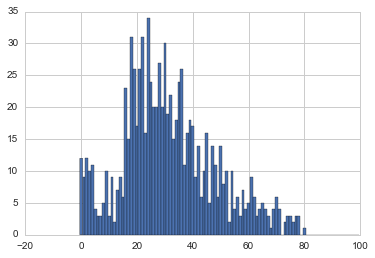

In [23]:
titanic.Age.describe()
plt.hist(titanic.Age, align='left', range=(0,100), bins=100)


In [24]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,SibSpIO,Family,FamilyIO,MaleFemale,child,female,male,clas_1,clas_2,clas_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,1,1,male,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,1,1,female,0.0,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,female,0.0,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,1,1,female,0.0,1.0,0.0,1.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,male,0.0,0.0,1.0,0.0,0.0,1.0


In [25]:
titanic.info()
print('---------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
C              891 non-null float64
Q              891 non-null float64
S              891 non-null float64
ParchIO        891 non-null int64
SibSpIO        891 non-null int64
Family         891 non-null int64
FamilyIO       891 non-null int64
MaleFemale     891 non-null object
child          891 non-null float64
female         891 non-null float64
male           891 non-null float64
clas_1         891 non-null float64
clas_2         891 non-null float64
clas_3         891 

In [57]:
#Doubts about if useful or even correct syntax or commands... but here it is...
titanic['Survived'].astype('category')
titanic.Age.astype('int64')
#titanic.Fare.astype('int64')
titanic.C.astype('category')
titanic.Q.astype('category')
titanic.S.astype('category')
titanic.child.astype('category')
titanic.female.astype('category')
titanic.male.astype('category')
titanic.clas_1.astype('category')
titanic.clas_2.astype('category')
titanic.clas_3.astype('category')
print()
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived    891 non-null int64
Age         891 non-null float64
C           891 non-null float64
Q           891 non-null float64
S           891 non-null float64
ParchIO     891 non-null int64
SibSpIO     891 non-null int64
child       891 non-null float64
female      891 non-null float64
male        891 non-null float64
clas_1      891 non-null float64
clas_2      891 non-null float64
clas_3      891 non-null float64
nullhyp     891 non-null int64
dtypes: float64(10), int64(4)
memory usage: 97.5 KB


We need to drop the columns that we consider either 

1) Irrelevant / No prediction power or 

2) No needed for our required level of complexity. 

I will leave the embarking port for now, even if this variable could be rather correlated to some other, or mean nothing too. 

Simplifications for initial attempt:

--keep separate Parch and SibSp dummy variables

--Ignore age 

--keep explicit variables for Pclass=3 and for 'child'

In [58]:
features = ['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family', 'FamilyIO', 'MaleFemale']
titanic = titanic.drop(features, axis=1)
test = test.drop(features, axis=1)

ValueError: labels ['PassengerId' 'Pclass' 'Name' 'Sex' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked' 'Family' 'FamilyIO' 'MaleFemale'] not contained in axis

In [28]:
titanic.head()

,Survived,Age,C,Q,S,ParchIO,SibSpIO,child,female,male,clas_1,clas_2,clas_3
0,0,22.0,0.0,0.0,1.0,0,1,0.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1.0,0.0,0.0,0,1,0.0,1.0,0.0,1.0,0.0,0.0
2,1,26.0,0.0,0.0,1.0,0,0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,1.0,0.0,0.0
4,0,35.0,0.0,0.0,1.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0


In [29]:
test.head()


,Age,C,Q,S,ParchIO,SibSpIO,child,female,male,clas_1,clas_2,clas_3
0,34.5,0.0,1.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
1,47.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0,0.0,1.0
2,62.0,0.0,1.0,0.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0
3,27.0,0.0,0.0,1.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
4,22.0,0.0,0.0,1.0,1,1,0.0,1.0,0.0,0.0,0.0,1.0


### Analysis

First let's define a function for extracting the fitting scores fo the different models\
Extracted from the model written by the Kaggle user 'vinceallenvince' (THANKS)


In [92]:
def check_classifiers(X, y):
    """
    Returns a sorted list of accuracy scores from fitting and scoring passed data
    against several alogrithms.
    """
    _cv = 4
    classifier_score = {}
    
    scores = cross_val_score(LogisticRegression(), X, y, cv=_cv)
    classifier_score['LogisticRegression'] = scores.mean()
    
    scores = cross_val_score(KNeighborsClassifier(), X, y, cv=_cv)
    classifier_score['KNeighborsClassifier'] = scores.mean()
    
    scores = cross_val_score(RandomForestClassifier(), X, y, cv=_cv)
    classifier_score['RandomForestClassifier'] = scores.mean()
    
    scores = cross_val_score(SVC(), X, y, cv=_cv)
    classifier_score['SVC'] = scores.mean()
    
    scores = cross_val_score(GaussianNB(), X, y, cv=_cv)
    classifier_score['GaussianNB'] = scores.mean()

    #return sorted(classifier_score.items(), key=operator.itemgetter(1), reverse=True)
    return sorted(classifier_score.items(), reverse=True)



### Null hypothesis

Let's check the null hypothesis first: I'll assume that everyone died ===> Survivor=0 for all samples

In [93]:
titanic['nullhyp'] = 0

In [94]:
titanic.head()


,Survived,Age,C,Q,S,ParchIO,SibSpIO,child,female,male,clas_1,clas_2,clas_3,nullhyp
0,0,22.0,0.0,0.0,1.0,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0
1,1,38.0,1.0,0.0,0.0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0
2,1,26.0,0.0,0.0,1.0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0
3,1,35.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0
4,0,35.0,0.0,0.0,1.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [95]:
features = ['nullhyp']
X_train = titanic[features]
y_train = titanic.Survived

check_classifiers(X_train, y_train)

[('SVC', 0.61616385964760412),
 ('RandomForestClassifier', 0.61616385964760412),
 ('LogisticRegression', 0.61616385964760412),
 ('KNeighborsClassifier', 0.61616385964760412),
 ('GaussianNB', 0.61616385964760412)]

In [96]:
model_lr1 = LogisticRegression()
model_lr1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
print(model_lr1.intercept_)
model_lr1.coef_

[-0.47104474]


array([[ 0.]])

In [98]:
print(np.exp(model_lr1.intercept_))
np.exp(model_lr1.coef_)

[ 0.62434965]


array([[ 1.]])

In [99]:
confusion_matrix(y_train, model_lr1.predict(X_train))

array([[549,   0],
       [342,   0]])

We can see how the scores of the models = 0.61, representing the actual proportion of survivors and victims.
The confusion matrix also represents this, with 342 false negatives (actual survivors) and 549 true negatives (actual victims). 

### Statistical models using the available data

In [100]:
#features = ['C', 'Q', 'S', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'male', 'clas_1', 'clas_2', 'clas_3']
features = ['C', 'Q', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'clas_1', 'clas_2']
X_train = titanic[features]
y_train = titanic.Survived

check_classifiers(X_train, y_train)

[('SVC', 0.7553150123217387),
 ('RandomForestClassifier', 0.78344287092185083),
 ('LogisticRegression', 0.80698087280906794),
 ('KNeighborsClassifier', 0.72733806436160697),
 ('GaussianNB', 0.75546087306877674)]

#### Logistic regression using sklearn

In [101]:
model_lr1 = LogisticRegression(C=1e4)
model_lr1.fit(X_train, y_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [102]:
print(model_lr1.intercept_)
model_lr1.coef_

[-2.15908317]


array([[ 0.65170208,  0.36428833, -0.01518764, -0.44977293, -0.31095197,
         2.69050713,  3.12802488,  2.22721917,  1.25672163]])

In [103]:
print(np.exp(model_lr1.intercept_))
np.exp(model_lr1.coef_)

[ 0.1154309]


array([[  1.918804  ,   1.4394892 ,   0.98492711,   0.63777295,
          0.73274907,  14.73914862,  22.82884531,   9.27404068,
          3.51388277]])

In [104]:
confusion_matrix(y_train, model_lr1.predict(X_train))

array([[480,  69],
       [ 93, 249]])

#### Logistic regression using StatsModel

In [105]:
#features = ['Survived', 'C', 'Q', 'S', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'male', 'clas_1', 'clas_2', 'clas_3']
features = ['Survived', 'C', 'Q', 'S', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'male', 'clas_1', 'clas_2', 'clas_3']
X_train = titanic[features]
y_train = titanic.Survived

'''#I will try to scale the dataframe to avoid isseus with 'Age'
scaler = preprocessing.Normalizer()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

X_scaled'''

"#I will try to scale the dataframe to avoid isseus with 'Age'\nscaler = preprocessing.Normalizer()\nscaler.fit(X_train)\nX_scaled = scaler.transform(X_train)\n\nX_scaled"

In [106]:
model_lr2 = smf.logit('Survived ~ Age + female + child + clas_1', data=X_train).fit()

Optimization terminated successfully.
         Current function value: 0.454745
         Iterations 6


In [107]:
print(model_lr2.summary())
print('------------------------------------------------------------------------------')
print(model_lr2.summary2())
print(np.exp(model_lr2.params))

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Oct 2016   Pseudo R-squ.:                  0.3171
Time:                        22:06:35   Log-Likelihood:                -405.18
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 3.668e-80
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.7506      0.246     -7.113      0.000        -2.233    -1.268
Age           -0.0144      0.006     -2.294      0.022        -0.027    -0.002
female         2.9481      0.204     14.454      0.0

#### Random Forest Classifier

In [108]:
#features = ['C', 'Q', 'S', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'male', 'clas_1', 'clas_2', 'clas_3']
features = ['C', 'Q', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'clas_1', 'clas_2']
X_train = titanic[features]
y_train = titanic.Survived

check_classifiers(X_train, y_train)

[('SVC', 0.7553150123217387),
 ('RandomForestClassifier', 0.77893841150567611),
 ('LogisticRegression', 0.80698087280906794),
 ('KNeighborsClassifier', 0.72733806436160697),
 ('GaussianNB', 0.75546087306877674)]

In [153]:
model_rf1 = RandomForestClassifier(max_depth=15, n_estimators=20)
model_rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [154]:
confusion_matrix(y_train, model_rf1.predict(X_train))

array([[527,  22],
       [ 40, 302]])

In [155]:
model_rf1.feature_importances_

array([ 0.02682154,  0.02444604,  0.41420177,  0.0289988 ,  0.03401208,
        0.04022915,  0.29040245,  0.08306946,  0.05781871])

In [156]:
model_rf1.score(X_train, y_train)

0.93041526374859707

In [157]:
model_rf1.classes_

array([0, 1])

### Predictions

In [158]:
test.head()

,Age,C,Q,S,ParchIO,SibSpIO,child,female,male,clas_1,clas_2,clas_3
0,34.5,0.0,1.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
1,47.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0,0.0,1.0
2,62.0,0.0,1.0,0.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0
3,27.0,0.0,0.0,1.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
4,22.0,0.0,0.0,1.0,1,1,0.0,1.0,0.0,0.0,0.0,1.0


In [159]:
features = ['C', 'Q', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'clas_1', 'clas_2']
X_test = test[features]

In [160]:
prediction = model_rf1.predict(X_test)

In [161]:
prediction

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1,

In [162]:
#join the predictions to the dataframe

In [163]:
testx = pd.read_csv('./Data_science/Titanic/test.csv')
testx.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [164]:
#features = ['C', 'Q', 'S', 'Age', 'ParchIO', 'SibSpIO', 'child', 'female', 'male', 'clas_1', 'clas_2', 'clas_3']
print(testx.columns)
print(test.columns)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['Age', 'C', 'Q', 'S', 'ParchIO', 'SibSpIO', 'child', 'female', 'male',
       'clas_1', 'clas_2', 'clas_3'],
      dtype='object')


In [165]:
test_prediction = pd.DataFrame({'PassengerId': testx['PassengerId'],
                  'Pclass': testx['Pclass'],
                  'Name': testx['Name'],
                  'Sex': testx['Sex'],
                  'Age': testx['Age'],
                  'SibSp': testx['SibSp'],
                  'Parch': testx['Parch'],
                  'Fare': testx['Fare'],
                  'Embarked': testx['Embarked'],
                  'Survived': prediction})

In [166]:
test_prediction

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,34.5,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,0
1,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,0
2,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,0
3,27.0,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,1
4,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,0
5,14.0,S,9.2250,"Svensson, Mr. Johan Cervin",0,897,3,male,0,0
6,30.0,Q,7.6292,"Connolly, Miss. Kate",0,898,3,female,0,1
7,26.0,S,29.0000,"Caldwell, Mr. Albert Francis",1,899,2,male,1,0
8,18.0,C,7.2292,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,900,3,female,0,0
9,21.0,S,24.1500,"Davies, Mr. John Samuel",0,901,3,male,2,0
